# <center>Introduction on Using Python to access GeoNet's GNSS data

In this notebook we will learn how to get data from one GNSS(Global Navigation Satellite System) station. By the end of this tutorial you will have make a graph like the one below. <img src="plot.png">

## &nbsp;Table of contents
### 1. Introduction
### 2. Building the base FITS query
### 3. Get GNSS data
### 4. Plot data 
### 5. Save data

## &nbsp;1. Introduction

In this tutorial we will be learning how to use Python to access GNSS (commonly referred to at GPS) data from the continuous GNSS sites in the GeoNet and PositioNZ networks.
GeoNet has a API (Application Programming Interface) to access its GNSS data. You do not need to know anything about APIs to use this tutorial. If you would like more info see https://fits.geonet.org.nz/api-docs/. 

To use this tutorial you will need to install the package pandas (https://pandas.pydata.org/).

This tutorial assumes that you have a basic knowledge of Python.

###### About GeoNet GNSS data

GeoNet uses GNSS technology to work out the precise positions of over 190 stations in and around NZ everyday. These positions are used to generate a displacement timeseries for each station, so we can observe how much and how quickly each station moves. <br>
This data comes split into 3 components:
<ul>
    <li> The displacement in the east-west direction where east is positive displacement. This data has a typeID of "e"
    <li> The displacement in the north-south direction where north is a positive displacement. This data has a typeID of "n"
    <li> The displacement in the up-down direction where up is a positive displacement. This data has a typeID of "u"</ul>
For more on data types go to http://fits.geonet.org.nz/type (for best formatting use firefox)   

## &nbsp;2. Building the base FITS query

###### Import packages

In [1]:
import requests
import pandas as pd
import datetime
import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters()

###### Set URL and endpoint

In [2]:
base_url = "http://fits.geonet.org.nz/"
endpoint = "observation"

The base URL should be set as above to access the FITS database webservice containing the GeoNet GNSS data. The endpoint is set to observation to get the data itself in csv format. There are other endpoints which will return different information such as plot and site. To learn more go to https://fits.geonet.org.nz/api-docs/

###### Combine URL and endpoint

In [3]:
url = base_url + endpoint

Combine the base URL and the endpoint to give the information to request the data.

## &nbsp;3. Get GNSS data

In this section we will learn how to get all the GNSS observation data from a site and put it into a pandas dataframe, so we can plot and save the data

###### Set query parameters

In [4]:
parameters ={"typeID": "e", "siteID": "HANM"}

Set the parameters to get the east component(`'typeID':'e'`) of the GNSS station in the Hanmer Basin (`'siteID': 'HANM'`). To find the 4 letter site ID of a station you can use https://www.geonet.org.nz/data/network/sensor/search to find stations in an area of interest

##### Get GNSS data

In [5]:
response_e = requests.get(url, params=parameters)

We use `requests.get` to get the data using the URL we made earlier and the parameters we set in the last stage

In [6]:
parameters["typeID"] = "n"
response_n = requests.get(url, params=parameters)
parameters["typeID"] = "u"
response_u = requests.get(url, params=parameters)

Here we've changed the typeID in the parameters dictionary to get the other components for the GNSS station

###### Check that your requests worked 

In [7]:
print ("The Response status code of the east channel is", response_e.status_code)
print ("The Response status code of the north channel is",response_n.status_code)
print ("The Response status code of the up channel is",response_u.status_code)

The Response status code of the east channel is 200
The Response status code of the north channel is 200
The Response status code of the up channel is 200


The response status code says whether we were successful in getting the data requested and why not if we were unsuccessful:
<ul>
<li>200 -- everything went okay, and the result has been returned (if any)
<li>301 -- the server is redirecting you to a different endpoint. This can happen when a company switches domain names, or an endpoint name is changed.
<li>400 -- the server thinks you made a bad request. This can happen when you don't send along the right data, among other things.
<li>404 -- the resource you tried to access wasn't found on the server.
</ul>

Now that we know our request for data was successful we want to transform it into a format that we can deal with in Python. Right now the data is one long string

###### Split the string of data

In [8]:
data_e = response_e.content.decode("utf-8").split("\n")

The above code decodes the response and then splits the east displacement data on the new line symbol as each line is one point of data. If you are using Python2 remove the code `.decode("utf-8")`

###### Split the points of data

In [9]:
for i in range(0, len(data_e)):
    data_e[i]= data_e[i].split(",")

The above code uses a for loop to split each point of data on the "," symbol as each value is separated by a ",", producing a list of lists

###### Reformat data values

In [10]:
for i in range(1, (len(data_e)-1)):
    data_e[i][0] = datetime.datetime.strptime(data_e[i][0], '%Y-%m-%dT%H:%M:%S.%fZ') #make 1st value into a datetime object
    data_e[i][1] = float(data_e[i][1]) #makes 2nd value into a decimal number
    data_e[i][2] = float(data_e[i][2]) #makes 3rd value into a decimal number

The above code uses a `for` loop to go over each point of data and reformat it, so that the first value in each point is seen as a time, and the second and third values are seen as numbers.<br>
Note that we choose to miss the first and last data points in our loop as the first data point has the names of the data values and the last point is empty due to how we split the data. 

###### Convert nested list into dataframe object

In [11]:
df_e = pd.DataFrame(data_e[1:-1],index = range(1, (len(data_e)-1)), columns=data_e[0])

`data_e[1:-1]` makes the list of data be the data in the data frame, `index = range(1, (len(data_e)-1))` makes rows named 1, 2, ... n where n is the number of data points, and  `columns=data_e[0]` gives the columns the names that where in the first line of the response string

###### Print the first few lines of the data frame

In [12]:
df_e.head()

,date-time,e (mm),error (mm)
1,2014-06-04 11:59:00,-424.02,2.02
2,2014-06-05 11:59:00,-419.77,1.70
3,2014-06-06 11:59:00,-415.43,1.91
4,2014-06-07 11:59:00,-418.94,1.85
5,2014-06-08 11:59:00,-419.47,1.65


Here we can see on the 4th of June 2014 how much the site HANM had moved east (with formal error) in mm from its reference position, this being the midpoint of the position timeseries.

###### Make everything we have just done into a function 

In [13]:
def GNSS_dataframe(data):
    """
    This function turns the string of GNSS data received by requests.get
    into a data frame with GNSS data correctly formatted.
    """
    data = data.split("\n") # splits data on the new line symbol
    for i in range(0, len(data)):
        data[i]= data[i].split(",")# splits data ponits on the , symbol
    for i in range(1, (len(data)-1)):
        data[i][0] = datetime.datetime.strptime(data[i][0], '%Y-%m-%dT%H:%M:%S.%fZ') #make 1st value into a datetime object
        data[i][1] = float(data[i][1]) #makes 2nd value into a decimal number
        data[i][2] = float(data[i][2]) #makes 3rd value into a decimal number
    df = pd.DataFrame(data[1:-1],index = range(1, (len(data)-1)), columns=data[0]) #make the list into a data frame
    return df 
df_e.head()

,date-time,e (mm),error (mm)
1,2014-06-04 11:59:00,-424.02,2.02
2,2014-06-05 11:59:00,-419.77,1.70
3,2014-06-06 11:59:00,-415.43,1.91
4,2014-06-07 11:59:00,-418.94,1.85
5,2014-06-08 11:59:00,-419.47,1.65


This makes code cells 8 to 11 into a function to be called later in the notebook.

###### Run the above function on the North and Up data 

In [14]:
df_n = GNSS_dataframe(response_n.content.decode("utf-8"))
df_u = GNSS_dataframe(response_u.content.decode("utf-8"))

Make sure to run this function on the content string of the requested data. If in Python2 use remove the code `.decode("utf-8")`

##### Why make the data into a data frame?

A data frame is a way of formatting data into a table with column and row name much like a csv file and makes long list of data a lot easier to use.  
Data frame data can be called by column or row name making it easy to get the point(s) of data you want. 
Data, much like in a table, can be “linked” so that you can do something like plot a data point on a 2D plot.
Sadly, data frames are not a built-in data format in Python, so we must use the pandas (https://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe) package to be able to make a data frame.  

## &nbsp;4. Plot data

###### Plot the east data

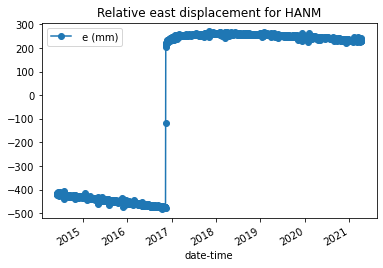

In [15]:
e_plot = df_e.plot(x='date-time', y= ' e (mm)', marker='o', title = 'Relative east displacement for HANM')
#plt.savefig("e_plot") 

The above code plots time on the x axis and the displacement in millimetres on the y axis. `marker = ‘o’` makes each point of data a small circle. If you want to save the plot as a png file in the folder you are running this code from you can uncomment ` plt.savefig("e_plot")`

###### Plot the north data

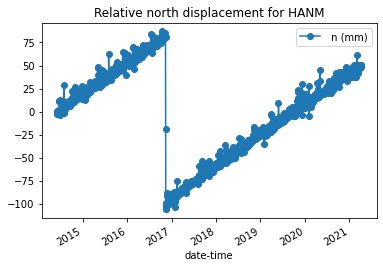

In [16]:
n_plot = df_n.plot(x='date-time', y= ' n (mm)', marker='o', title = 'Relative north displacement for HANM')
#plt.savefig("n_plot") 

###### Plot the up data

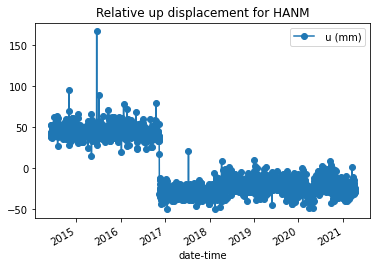

In [17]:
u_plot = df_u.plot(x='date-time', y= ' u (mm)', marker='o', title='Relative up displacement for HANM')
#plt.savefig("u_plot") 

## &nbsp;5. Save data

##### Make a copy of the east data frame

In [18]:
df = df_e

This makes what is call a deep copy of the data frame with the east displacement data in it. This means that if `df` is edited `df_e` is not effected.

###### Remove the error column from this copy of the data

In [19]:
df = df.drop(" error (mm)",axis=1)

The above code removes the column called error (mm) and all its data from `df`. ` axis=1` says that we are looking for a column. If we put ` axis=0` we would be looking for a row. 

###### Add the up and north data to this data frame (but not the respective errors)

In [20]:
df["u (mm)"] =  df_u[' u (mm)']
df["n (mm)"] =  df_n[' n (mm)']

###### Print the first few lines of the data frame

In [21]:
df.head()

,date-time,e (mm),u (mm),n (mm)
1,2014-06-04 11:59:00,-424.02,52.09,1.16
2,2014-06-05 11:59:00,-419.77,43.39,-1.70
3,2014-06-06 11:59:00,-415.43,41.41,-2.03
4,2014-06-07 11:59:00,-418.94,52.78,-0.52
5,2014-06-08 11:59:00,-419.47,37.66,-0.64


Here we can see the layout of the data frame with the columns date, east displacement, up displacement and north displacement 

###### Save as CSV file

In [22]:
df.to_csv("HANM.csv")

This saves the data frame csv file with the same formatting as the data frame. It will have saved in the same place as this notebook is run from and be named HANM

## Useful links

<ul>
    <li>This notebook uses Python https://www.python.org/
    <li>This notebook also uses pandas https://pandas.pydata.org/
    <li>There is a notebook on this data set in R at https://github.com/GeoNet/data-tutorials/tree/master/GNSS_Data/R/Introduction_to_GNSS_data_using_FITS_in_R.ipynb 
    <li>More tutorials on GNSS data can be found at https://github.com/GeoNet/data-tutorials/tree/master/GNSS_Data/R  
    <li>To learn more about station codes go to https://www.geonet.org.nz/data/supplementary/channels
    <li>For more on data types in FITS go to http://fits.geonet.org.nz/type (for best formatting use firefox)
    <li>For more on FITS go to https://fits.geonet.org.nz/api-docs/   
</ul>